In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

df = pd.read_csv("data/Historical Product Demand.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%Y/%m/%d")
df["Order_Demand"] = pd.to_numeric(df["Order_Demand"], errors="coerce")

In [15]:
### Calculate monthly demand
monthly = (
    df.groupby([
        "Warehouse",
        "Product_Code",
        pd.Grouper(key="Date", freq="MS")  # Month Start
    ])["Order_Demand"]
    .sum()
    .reset_index()
)

# Determining seasonality

Before making a function to apply to all products, let's start with a subset 

In [16]:
warehouse = "Whse_A"
product_code = "Product_0001"

df_subset = monthly[(monthly["Warehouse"] == warehouse) & (monthly["Product_Code"] == product_code)]

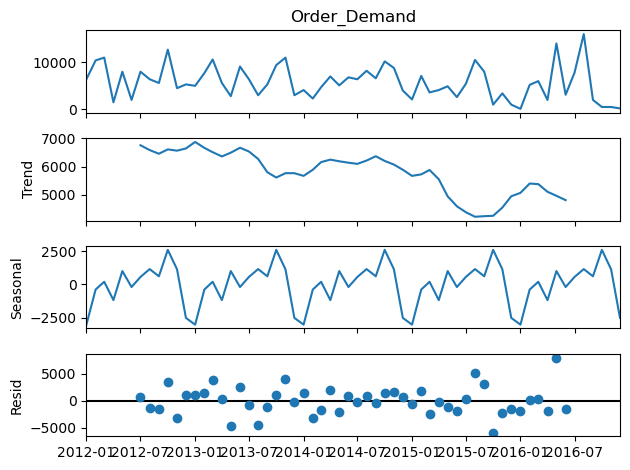

In [17]:
series = (
    df_subset
    .set_index("Date")["Order_Demand"]
    .asfreq("MS")
)
series = series.fillna(0)

result = seasonal_decompose(series, model="additive", period=12)

result.plot()
plt.show()

**Trend** - The decreasing trend shows a decrease in demand over the last 4 years... however, over the last year this trend has actually been increasing.

**Seasonal** - There are major dropoffs in demand at the beginning of the year and increases during the last couple of months.

# Determining a model

We will run 3 different models to see what gives us the best forecast:

1. Exponential smoothing - captures level + trend + seasonality
2. SARIMA - handles autoregression, differencing (for non-stationary trends), moving averages, and seasonality
3. ARIMA - same as model 2 but without seasonality

## Exponential smoothing

In [18]:
ets_model = ExponentialSmoothing(
    series, trend="add", seasonal="add", seasonal_periods=12
).fit()
ets_forecast = ets_model.forecast(12)  # 12 months ahead

c:\Users\atama\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## SARIMA

### Stationarity

In [19]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(series)
print("ADF p-value:", adf_result[1]) # < 0.05 suggests stationarity

ADF p-value: 0.0005619164094078265


This suggests stationarity, so no differencing is needed

### ACF/PACF

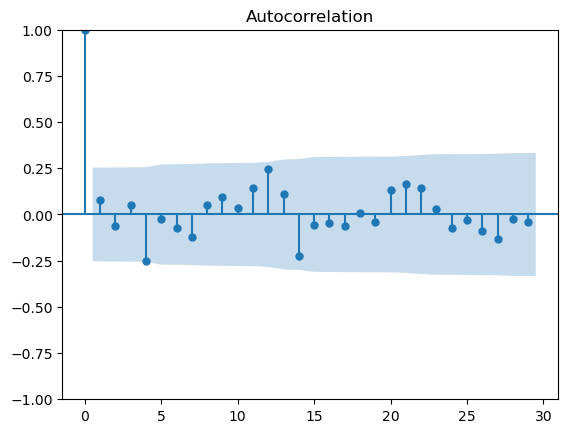

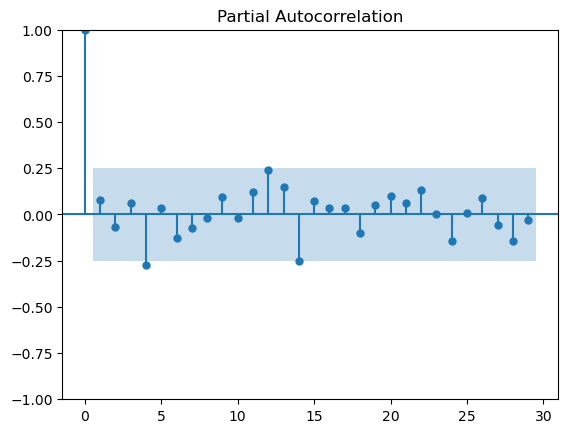

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
max_lags = len(series) // 2 - 1  # = 29 for 60 months

plot_acf(series.dropna(), lags=max_lags);
plot_pacf(series.dropna(), lags=max_lags);

* The ACF gives no real moving average component
* The PACF gives a weak MA(4) component

In [21]:
### Model with no seasonality
model = SARIMAX(series, order=(4,1,0), seasonal_order=(0,0,0,0))
fit = model.fit()
sarima_forecast_no_seasonality = fit.get_forecast(12).predicted_mean

### Model with seasonality
model = SARIMAX(series, order=(4,1,0), seasonal_order=(0,1,0,12))
fit = model.fit()
sarima_forecast_seasonality = fit.get_forecast(12).predicted_mean

## Evaluating models

Now that we have our 3 models, let's compare them using MAPE

In [22]:
import numpy as np

### Train/test split
h = 12 # 12 periods
train, test = series.iloc[:-h], series.iloc[-h:]

# ETS
ets_model = ExponentialSmoothing(
    train, trend="add", seasonal="add", seasonal_periods=12
).fit()
ets_forecast = ets_model.forecast(h)

# SARIMA no seasonality
sarima_ns = SARIMAX(train, order=(4,1,0), seasonal_order=(0,0,0,0))
fit_ns = sarima_ns.fit(disp=False)
sarima_fc_ns = fit_ns.get_forecast(h).predicted_mean

# SARIMA with seasonality
sarima_s = SARIMAX(train, order=(4,1,0), seasonal_order=(0,1,0,12))
fit_s = sarima_s.fit(disp=False)
sarima_fc_s = fit_s.get_forecast(h).predicted_mean

def evaluate(y_true, y_pred, name):
    wape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100
    print(f"{name} -> WAPE: {wape:.2f}%")

evaluate(test, ets_forecast, "ETS")
evaluate(test, sarima_fc_ns, "SARIMA (no seasonality)")
evaluate(test, sarima_fc_s, "SARIMA (with seasonality)")

ETS -> WAPE: 92.18%
SARIMA (no seasonality) -> WAPE: 87.28%
SARIMA (with seasonality) -> WAPE: 87.27%


c:\Users\atama\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


These WAPE values are incredibly high, indicating that these models will not be very useful in forecasting demand. So let's try 2 simpler models:

1. Naive forecast - last observed value
2. Average of last 12 months


In [23]:
# Naive: forecast = last observed value, repeated h times
naive_forecast = pd.Series(
    [train.iloc[-1]] * h, 
    index=test.index
)

# Average of last 12 months
last_12_avg = train.iloc[-12:].mean()
avg12_forecast = pd.Series(
    [last_12_avg] * h,
    index=test.index
)

evaluate(test, naive_forecast, "Naive")
evaluate(test, avg12_forecast, "Last-12-Months Average")

Naive -> WAPE: 88.50%
Last-12-Months Average -> WAPE: 86.32%


The last 12 months average gives a lower WAPE than all of the other models, suggesting that the data is very noisy or intermittent.

But given we observed a seasonal shift, let's see how good of a model can be built using `Forecast = demand from the same month last year.`

In [24]:
seasonal_naive_forecast = series.shift(12).iloc[-h:]
evaluate(test, seasonal_naive_forecast, "Seasonal Naive")

Seasonal Naive -> WAPE: 62.89%


This gives us our best model by far. 

# Automation

Given that thousands of products exist, we need some way to automate this process. Therefore, we will write a custom function found in `forecast_demand.py` to give us the WAPE of each model for any given `Warehouse` + `Product Code` pair.

In [25]:
from pmdarima import auto_arima

def calculate_wape(y_true, y_pred):
    wape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100
    return wape

def forecast_wapes(df: pd.DataFrame, warehouse: str, product_code: str) -> list:

    ### Subset based on warehouse and product code
    df_subset = df[(df["Warehouse"] == warehouse) & (df["Product_Code"] == product_code)]

    ### Create time series
    series = (
        df_subset
        .set_index("Date")["Order_Demand"]
        .asfreq("MS")
    )
    series = series.fillna(0)

    ### Train/test split
    h = 12 # 12 periods
    train, test = series.iloc[:-h], series.iloc[-h:]

    # Last month
    naive_forecast = pd.Series(
        [train.iloc[-1]] * h, 
        index=test.index
    )

    # Average of last 12 months
    last_12_avg = train.iloc[-12:].mean()
    avg12_forecast = pd.Series(
        [last_12_avg] * h,
        index=test.index
    )

    # Same month of last year
    seasonal_naive_forecast = series.shift(12).iloc[-h:]

    # ETS
    ets_model = ExponentialSmoothing(
        train, trend="add", seasonal="add", seasonal_periods=12
    ).fit()
    ets_forecast = ets_model.forecast(h)

    # ARIMA No seasonality
    arima_s = auto_arima(
        train,
        seasonal=True,
        m=12,
        stepwise=True
    )
    sarima_forecast_no_seasonality = arima_s.predict(n_periods=h)

    # SARIMA w/ seasonality
    arima_s2 = auto_arima(
        train,
        stepwise=True
    )
    sarima_forecast_seasonality = arima_s2.predict(n_periods=h)

    ### Calculate WAPEs
    wape_values = []

    wape_values.append(calculate_wape(test, naive_forecast))
    wape_values.append(calculate_wape(test, avg12_forecast))
    wape_values.append(calculate_wape(test, seasonal_naive_forecast))
    wape_values.append(calculate_wape(test, ets_forecast))
    wape_values.append(calculate_wape(test, sarima_forecast_no_seasonality))
    wape_values.append(calculate_wape(test, sarima_forecast_seasonality))

    return wape_values

This would take hours to run, so we'll use a sample of 10 product-warehouse combinations to show that it works.

In [27]:
unique_pairs = monthly[["Warehouse", "Product_Code"]].drop_duplicates().head(10)

all_wapes = {}

for _, row in unique_pairs.iterrows():
    warehouse = row["Warehouse"]
    product = row["Product_Code"]

    try:
        wapes = forecast_wapes(monthly, warehouse, product)
    except:
        wapes = []

    all_wapes[(warehouse, product)] = wapes

# convert to DataFrame
pair_wapes = pd.DataFrame.from_dict(
    all_wapes,
    orient="index",
    columns=[
        "Last_Month_WAPE",
        "Last_12_WAPE",
        "Seasonal_12_WAPE",
        "ETS_WAPE",
        "ARIMA_WAPE",
        "SARIMA_WAPE"
    ]
).reset_index()

# split tuple key into Warehouse and Product_Code
pair_wapes[["Warehouse", "Product_Code"]] = pd.DataFrame(pair_wapes["index"].tolist(), index=pair_wapes.index)

# drop old index col and reorder
pair_wapes = pair_wapes.drop(columns="index")[
    ["Warehouse", "Product_Code", "Last_Month_WAPE", "Last_12_WAPE", "Seasonal_12_WAPE", "ETS_WAPE", "ARIMA_WAPE", "SARIMA_WAPE"]
]

c:\Users\atama\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\atama\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\atama\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\atama\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\atama\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\atama\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to co

In [28]:
print(pair_wapes)

  Warehouse  Product_Code  Last_Month_WAPE  Last_12_WAPE  Seasonal_12_WAPE  \
0    Whse_A  Product_0001        88.501742     86.324042         62.891986   
1    Whse_A  Product_0020        59.602649     44.812362         92.715232   
2    Whse_A  Product_0031       132.894737     33.223684         61.184211   
3    Whse_A  Product_0075       100.000000    100.000000         44.444444   
4    Whse_A  Product_0078        89.385475     73.091248        158.100559   
5    Whse_A  Product_0081       100.000000     73.456790         85.802469   
6    Whse_A  Product_0091       100.000000     64.500000         93.000000   
7    Whse_A  Product_0097       125.587467    228.981723        287.467363   
8    Whse_A  Product_0119       100.000000     77.414075         73.322422   
9    Whse_A  Product_0120        74.161627     48.506505        117.262232   

     ETS_WAPE  ARIMA_WAPE  SARIMA_WAPE  
0   92.177241   94.555749    94.555749  
1   73.105632   63.038079    63.038079  
2   64.891516   68

This process works for as many different warehouse-product combinations as needed.

## Function 2: Using best forecast

In [29]:
MODEL_NAMES = [
    "Last_Month",      
    "Last_12_Avg",     
    "Seasonal_Naive",   
    "ETS",        
    "ARIMA",      
    "SARIMA"    
]

def best_future_forecast(df: pd.DataFrame, warehouse: str, product_code: str, h: int = 12):
    """
    Uses forecast_wapes() to pick the best model (lowest WAPE),
    then fits that same model on the FULL series (df) and produces an h-step forecast.
    Returns: (best_model_name, best_wape, forecast_series)
    """
    # 1) Get WAPEs from your unchanged function
    wapes = forecast_wapes(df, warehouse, product_code)
    best_idx = int(np.nanargmin(wapes))  # pick lowest WAPE (ignores NaNs)

    # 2) Rebuild the FULL series from df (same steps as in your function)
    df_subset = df[(df["Warehouse"] == warehouse) & (df["Product_Code"] == product_code)]
    series = (
        df_subset
        .set_index("Date")["Order_Demand"]
        .asfreq("MS")
    ).fillna(0)

    # 3) Future index
    last_date = series.index.max()
    future_index = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=h, freq="MS")

    # 4) Fit the selected model on the FULL series & forecast
    if best_idx == 0:
        # Last month (repeat last observed)
        y_last = series.iloc[-1]
        forecast = pd.Series([y_last] * h, index=future_index)

    elif best_idx == 1:
        # Average of last 12 months (repeat)
        y_avg12 = series.iloc[-12:].mean()
        forecast = pd.Series([y_avg12] * h, index=future_index)

    elif best_idx == 2:
        # Seasonal naive = repeat last 12 months pattern
        vals = series.iloc[-12:].values
        # if h > 12, tile; else take first h
        reps = int(np.ceil(h / 12))
        forecast_vals = np.tile(vals, reps)[:h]
        forecast = pd.Series(forecast_vals, index=future_index)

    elif best_idx == 3:
        # ETS on full series
        ets_model = ExponentialSmoothing(series, trend="add", seasonal="add", seasonal_periods=12).fit()
        forecast = pd.Series(ets_model.forecast(h), index=future_index)

    elif best_idx == 4:
        # auto_arima with seasonal=True, m=12
        arima_s = auto_arima(series, seasonal=True, m=12, stepwise=True)
        forecast = pd.Series(arima_s.predict(n_periods=h), index=future_index)

    else:
        # auto_arima without seasonal args
        arima_s2 = auto_arima(series, stepwise=True)
        forecast = pd.Series(arima_s2.predict(n_periods=h), index=future_index)

    return MODEL_NAMES[best_idx], float(wapes[best_idx]), forecast

And to test this...

c:\Users\atama\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


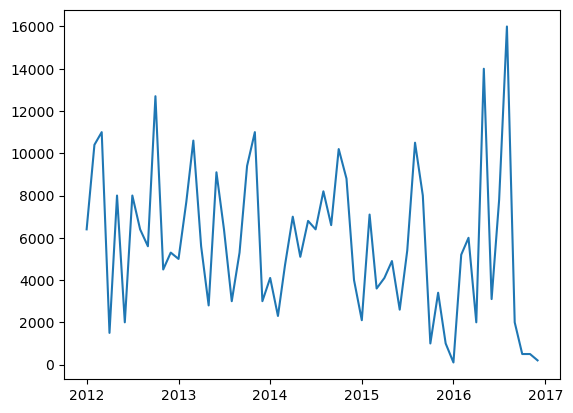

In [ ]:
### Product 0001
def plot_product_demand_forecast(df: pd.DataFrame, warehouse: str, product: str):

    product_1 = df[(df["Warehouse"] == warehouse) & (df["Product_Code"] == product)]
    model_name, wape, forecast = best_future_forecast(df, warehouse, product)

    if not isinstance(forecast, pd.Series):
        # assume forecast is an array → build an index starting after last date
        last_date = product_1['Date'].max()
        forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(),
                                    periods=len(forecast), freq="MS")
        forecast = pd.Series(forecast, index=forecast_index)

    plt.plot(
        product_1['Date'],
        product_1['Order_Demand']
    )
    plt.plot(forecast.index, forecast.values, label=f"Forecast ({model_name})", linestyle="--")

    plt.title(f"{product} - Best model: {model_name}, WAPE={wape:.2f}%")
    plt.xlabel("Date")
    plt.ylabel("Order Demand")

    plt.show()

plot_product_demand_forecast(monthly, "Whse_A", "Product_0001")